In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
np.set_printoptions(precision=3)
# better display of review text in dataframes
pd.set_option('display.max_colwidth', None) 

# Seaborn options
sns.set(style="whitegrid", font_scale=1.4)

# Auto reload modules
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
assert tf.__version__ >= "2.0"

In [4]:
import re
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Prepare data

## Load dataset

In [5]:
import pandas as pd
file_name='C:/Users/21264/Desktop/S8/STAGE LIP6/TEST/JURI.csv'
data_df = pd.read_csv(file_name,delimiter=";")
data_df=data_df.dropna(how = 'any')
data_df

idx                        formation  \
0     JURITEXT000006951617                 CHAMBRES_REUNIES   
3     JURITEXT000006952583                 CHAMBRES_REUNIES   
4     JURITEXT000006952707                 CHAMBRES_REUNIES   
5     JURITEXT000006952821                 CHAMBRES_REUNIES   
6     JURITEXT000006952824                 CHAMBRES_REUNIES   
...                    ...                              ...   
2251  JURITEXT000035963201                             AVIS   
2254  JURITEXT000035965566  COMMISSION_REPARATION_DETENTION   
2255  JURITEXT000035965597  COMMISSION_REPARATION_DETENTION   
2256  JURITEXT000035965614  COMMISSION_REPARATION_DETENTION   
2257  JURITEXT000035965637  COMMISSION_REPARATION_DETENTION   

                        solution        date  \
0                          REJET  1862-04-24   
3                     ANNULATION  1898-01-31   
4                      Cassation  05/08/1941   
5                      Cassation  13/02/1930   
6                      CASSATION  13/01/1932   
...                          ...         ...   
2251            Avis sur saisine  12/07/2017   
2254  Accueil partiel du recours  12/09/2017   
2255  Accueil partiel du recours  12/09/2017   
2256  Accueil partiel du recours  12/09/2017   
2257  Accueil partiel du recours  12/09/2017   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [6]:
data_df = pd.DataFrame({'content':data_df['content'],'solution':data_df['solution']})
data_df['solution']=data_df['solution'].str.lower()
data_df

content  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [7]:
resultat = data_df.groupby('solution')['content'].nunique()
resultat

solution
accueil du recours                                                                      12
accueil partiel du recours                                                              18
admission                                                                                3
annulation                                                                               5
annulation partielle                                                                     1
annulation sans renvoi                                                                   7
autres                                                                                   1
avis                                                                                    14
avis sur saisine                                                                        25
cassation                                                                              240
cassation                                                                        

In [8]:
seuil=20
data_df = data_df[data_df.groupby('solution').solution.transform('count')>seuil].copy() 
data_df
resultat = data_df.groupby('solution')['content'].nunique()
resultat


solution
avis sur saisine          25
cassation                240
cassation partielle       35
cassation sans renvoi     33
infirmation partielle     29
irrecevabilité            33
rejet                    270
Name: content, dtype: int64

In [9]:
corpus_docs = []
n = len(data_df)
corpus_docs = corpus_docs + data_df.iloc[:,0].tolist()
corpus_labels = list(data_df['solution'])

In [10]:
corpus_labels[0:2],corpus_docs[0:2]

(['rejet', 'cassation'],
 ["REJET du pourvoi formé par Zoé - Marie - Louise Herbin contre un Arrêt rendu par la Cour impériale d ' orléans , le 6 juillet 1861 , en faveur du sieur X ..., son mari . Du 24 Avril 1862 . LA COUR , chambres réunies , Ouï M . Legagneur , conseiller , en son rapport ; Maître Ambroise A ..., en ses observations , à l ' audience publique du 22 avril ; Maître Z ..., en ses observations , et M . le procureur général Dupin , en ses conclusions , à l ' audience publique d ' hier ; Vidant le délibéré en chambre du conseil ; Attendu que l ' erreur dans la personne dont les articles 146 et 180 du Y ... Napoléon ont fait une cause de nullité du mariage ne s ' entend , sous la nouvelle comme sous l ' ancienne législation , que d ' une erreur portant sur la personne elle - même ; Attendu que si la nullité , ainsi établie , ne doit pas être restreinte au cas unique de l ' erreur provenant d ' une substitution frauduleuse de personne au moment de la célébration ; Si elle p

In [11]:
data_df['category_id'] = data_df['solution'].factorize()[0]
category_id_df = data_df[['solution', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'solution']].values)

# New dataframe
data_df.head()

,content,solution,category_id
0,"REJET du pourvoi formé par Zoé - Marie - Louise Herbin contre un Arrêt rendu par la Cour impériale d ' orléans , le 6 juillet 1861 , en faveur du sieur X ..., son mari . Du 24 Avril 1862 . LA COUR , chambres réunies , Ouï M . Legagneur , conseiller , en son rapport ; Maître Ambroise A ..., en ses observations , à l ' audience publique du 22 avril ; Maître Z ..., en ses observations , et M . le procureur général Dupin , en ses conclusions , à l ' audience publique d ' hier ; Vidant le délibéré en chambre du conseil ; Attendu que l ' erreur dans la personne dont les articles 146 et 180 du Y ... Napoléon ont fait une cause de nullité du mariage ne s ' entend , sous la nouvelle comme sous l ' ancienne législation , que d ' une erreur portant sur la personne elle - même ; Attendu que si la nullité , ainsi établie , ne doit pas être restreinte au cas unique de l ' erreur provenant d ' une substitution frauduleuse de personne au moment de la célébration ; Si elle peut également recevoir son application quand l ' erreur procède de ce que l ' un des époux s ' est fait agréer en se présentant comme membre d ' une famille qui n ' est pas la sienne , et s ' est attribué les conditions d ' origine et la filiation qui appartiennent à un autre ; Le texte et l ' esprit de l ' article 180 écartent virtuellement de sa disposition les erreurs d ' une autre nature , et n ' admettent la nullité que pour l ' erreur qui porte sur l ' identité de la personne et par le résultat de laquelle l ' une des parties a épousé une personne autre que celle à qui elle croyait s ' unir ; Qu ' ainsi la nullité pour erreur dans la personne reste sans extension possible aux simples erreurs sur des conditions ou des qualités de la personne , sur des flétrissures qu ' elle aurait subies , et spécialement à l ' erreur de l ' époux qui a ignoré la condamnation à des peines afflictives ou infamantes antérieurement prononcées contre son conjoint , et la privation des droits civils et civiques qui s ' en est suivie ; Que la déchéance établie par l ' article 34 du Code pénal ne constitue par elle - même ni un empêchement au mariage ni une cause de nullité de l ' union contractée ; Qu ' elle ne touche non plus en rien à l ' identité de la personne ; qu ' elle ne peut donc motiver une action en nullité du mariage pour erreur dans la personne ; Qu ' en le jugeant ainsi et en rejetant la demande en nullité de son mariage formée par Zoé Herbin , et motivée sur l ' ignorance où elle avait été à l ' époque du mariage de la condamnation à quinze ans de travaux forcés qu ' avait antérieurement subie Berthon , son mari , et de la privation des droits civils et civiques qui en avait été la suite , l ' arrêt attaqué n ' a fait qu ' une juste et saine application des articles 146 et 180 du Y ... Napoléon . LA COUR REJETTE , Ainsi fait et prononcé , Chambres réunies .",rejet,0
4,"CASSATION , sur le pourvoi de l ' Agence Havas , d ' un jugement rendu , le 8 novembre 1935 , par le conseil de prud & quot ; hommes d ' Aix - en - Provence , au profit du sieur X .... LA COUR , statuant toutes chambres réunies , Ouï , M . le conseiller Debue en son rapport , MM . Y ... et Chévrier , avocats en la Cour , en leurs observations , et M . le procureur général en ses conclusions ; Et après en avoir délibéré , conformément à la loi ; Sur l ' unique moyen de cassation : Vu l ' article 1315 du Code civil ; Attendu qu ' il appartient à celui qui réclame l ' exécution d ' une obligation d ' en rapporter la preuve ; Attendu que X ..., employé à la succursale de l ' Agence Havas à Marseille , congédié le 24 mars 1934 , avec un préavis d ' un mois , a assigné son employeur devant le conseil de prud & quot ; hommes en paiement d ' une indemnité de 950 francs qu ' il prétend lui être due en vertu d ' une décision du conseil d ' administration qui , portée à la connaissance des intéressés le 6 juin 1934 , allouait à tous les agents de cette société une gratification égale aux ap

## TFIDF

The text needs to be transformed to vectors so as the algorithms will be able make predictions. In this case it will be used the Term Frequency – Inverse Document Frequency (TFIDF) weight to evaluate __how important a word is to a document in a collection of documents__.

After removing __punctuation__ and __lower casing__ the words, importance of a word is determined in terms of its frequency.




## TF-IDF

****### “Term Frequency – Inverse Document Frequency 

__TF-IDF__ is the product of the __TF__ and __IDF__ scores of the term.<br><br> $$\text{TF-IDF}=\frac{\text{TF}}{\text{IDF}}$$<br>

__Term Frequency :__ This summarizes how often a given word appears within a document.

$$\text{TF} = \frac{\text{Number of times the term appears in the doc}}{\text{Total number of words in the doc}}$$<br><br>
__Inverse Document Frequency:__ This downscales words that appear a lot across documents. A term has a high IDF score if it appears in a few documents. Conversely, if the term is very common among documents (i.e., “the”, “a”, “is”), the term would have a low IDF score.<br>

$$\text{IDF} = \ln\left(\frac{\text{Number of docs}}{\text{Number docs the term appears in}} \right)$$<br>

TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents. The higher the TFIDF score, the rarer the term is. For instance, in a Mortgage complaint the word _mortgage_ would be mentioned fairly often. However, if we look at other complaints, _mortgage_ probably would not show up in many of them. We can infer that _mortgage_ is most probably an important word in Mortgage complaints as compared to the other products. Therefore, _mortgage_ would have a high TF-IDF score for Mortgage complaints.

TfidfVectorizer class can be initialized with the following parameters:
* __min_df__: remove the words from the vocabulary which have occurred in less than ‘min_df’ number of files.
* __max_df__: remove the words from the vocabulary which have occurred in more than _‘max_df’ * total number of files in corpus_.
* __sublinear_tf__: set to True to scale the term frequency in logarithmic scale.
* __stop_words__: remove the predefined stop words in 'english'.
* __use_idf__: weight factor must use inverse document frequency.
* __ngram_range__: (1, 2) to indicate that unigrams and bigrams will be considered.

In [12]:




tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2))

# We transform each complaint into a vector
features = tfidf.fit_transform(data_df.content).toarray()

labels = data_df.category_id

print("Chacune des %d  jurisprudences est représentée par %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))







    
    
    


Chacune des 665  jurisprudences est représentée par 18674 features (TF-IDF score of unigrams and bigrams)


In [13]:
# Finding the three most correlated terms with each of the product categories
N = 10
for solution, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(solution))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))
    
    
    
    


==> avis sur saisine:
  * Most Correlated Unigrams are: avis, louvel, reçue, orales, formulée, 1031, référendaire, libellée, 441, séance
  * Most Correlated Bigrams are: référendaire rapporteur, la séance, ainsi libellée, avis formulée, avis été, articles 441, présent avis, 441 et, de chambre, est avis

==> cassation:
  * Most Correlated Unigrams are: etaient, meme, consequence, parties, ledit, annule, casse, renvoie, remet, semblable
  * Most Correlated Bigrams are: rendu entre, et pour, avant ledit, fait droit, droit les, les renvoie, remet en, parties au, renvoie devant, et semblable

==> cassation partielle:
  * Most Correlated Unigrams are: ester, collaboration, résolu, comparaître, consistant, défenseur, fournisseur, médical, quant, résolution
  * Most Correlated Bigrams are: résolution de, arrêt partiellement, la résolution, résolution du, mais seulement, seulement en, annule mais, conséquence quant, ce la, quant ce

==> cassation sans renvoi:
  * Most Correlated Unigrams are: 

## Multi-Classification models

The classification models evaluated are: 
* Random Forest
* Linear Support Vector Machine
* Multinomial Naive Bayes 
* Logistic Regression.

In [14]:
X = data_df['content'] # Collection of documents
y = data_df['solution'] # Target or the labels we want to predict 

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

MODELS

In [15]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

## Comparison of model performance

The best mean acuracy was obtained with LinearSVC.

In [16]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.796992,0.095699
LogisticRegression,0.730827,0.072196
MultinomialNB,0.609023,0.082877
RandomForestClassifier,0.804511,0.033625


In [17]:
## Model evaluation

In [18]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               data_df.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [19]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= data_df['solution'].unique()))

				CLASSIFICATIION METRICS

                       precision    recall  f1-score   support

                rejet       0.86      0.95      0.90        80
            cassation       0.83      0.94      0.88        53
  cassation partielle       0.00      0.00      0.00        10
       irrecevabilité       0.60      0.33      0.43         9
cassation sans renvoi       1.00      0.20      0.33         5
infirmation partielle       0.86      1.00      0.92         6
     avis sur saisine       1.00      1.00      1.00         4

             accuracy                           0.84       167
            macro avg       0.74      0.63      0.64       167
         weighted avg       0.80      0.84      0.80       167



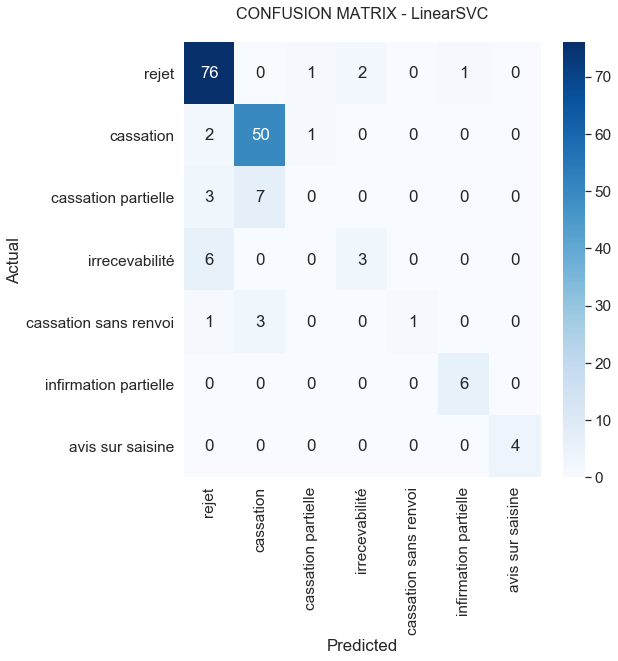

In [20]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.solution.values, 
            yticklabels=category_id_df.solution.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);